### code from: https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

/home/nihang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [3]:
# mnist dataset
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [4]:
# Load data
data = mnist_data()
# Create data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
# Num batches
num_batches = len(data_loader)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 12534055.04it/s]


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 25074662.35it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 8010558.21it/s]


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 8211434.81it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw



## Networks

In [5]:
# GAN includes a Generator G(z, theta) and a Discriminator D(G(z))
## The discriminator is to distinguish the input data as real or fake.
## which is to maximize D(x), and also minimize D(G(z))

## The generator is to generate data that can fool the discriminator.
## The goal of generator is to maximize D(G(z))

In [6]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        ## input size 28*28
        n_features = 784
        n_out = 1
        
        ## use leakyReLU as activation function
        ## leakyrelu: f(x)=x if x>0 else ax
        ## dropout rate: 0.3
        ## 784 --> 1024 --> 512 --> 256 --> 1
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    # 28x28 --> 784
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [7]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        ## output vector will be reorgnized to 28*28 as the fake image
        n_features = 100
        n_out = 784
        
        
        ## 100 -> 256 -> 512 -> 1024 -> 784
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    ## generate a set of noise sample (number: size, length: 100) from the noise prior
    ## the difference between Variable and tensor is that variable can do the backpropagation
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [8]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

# check cuda...I do not use cuda in this machine
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    discriminator.cuda()
    generator.cuda()

## Optimization

In [9]:
# Optimizers
## learning rate 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
## use binary cross entropy as loss function (real or fake)
# l = -w[ylogv + (1-y)log(1-v)]
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

## Training

In [10]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # 1. Train Discriminator
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

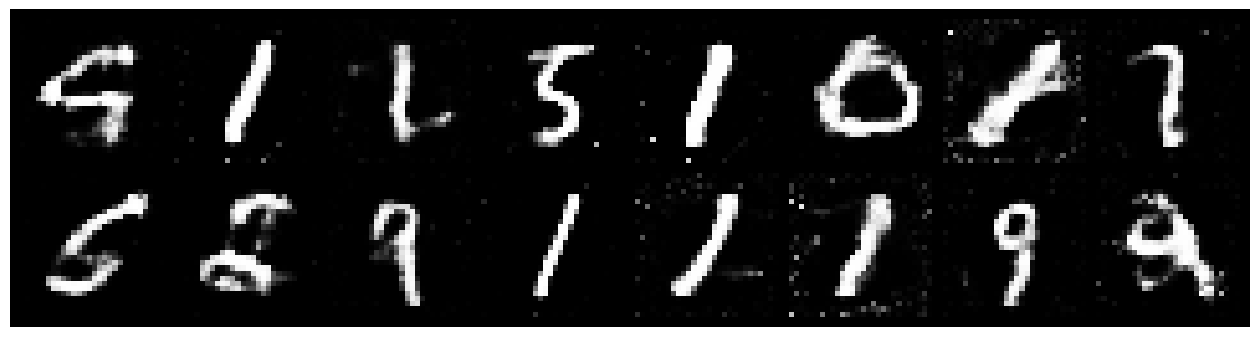

Epoch: [199/200], Batch Num: [750/938]
Discriminator Loss: 1.4543, Generator Loss: 0.8670
D(x): 0.4660, D(G(z)): 0.4478


In [13]:
logger = Logger(model_name='VGAN', data_name='MNIST')


# training process as:
## generate fake data using generator, 
## and then use real and fake data to train the discriminator

## Then train the generator.
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 250 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)